Welcome!

This notebook is going to be a short exploration of how we might go about trying to make a smart CCTV, one which would be able to identify suspicious behaviour without the need of a human watching along. 

We we will be working with the following two videos throughout this project for testing

<centre>
    <video controls src="data\testingdata\street.mp4" width="50%" />
</centre>

Video 1 : People walking past a street at night

<centre>
    <video controls src="data\testingdata\subway.mp4" width="50%" />
</centre>

Video 2: People rushing through the subway


In [2]:
## Import useful libraries

import cv2 
import numpy as np
import os
import matplotlib.pyplot as plt
import cvlib as cv
from cvlib.object_detection import draw_bbox

# How do we detect change in video

First of all, it would be nice if we could detect changes between two frames. The simplest solution would just be considering the difference of the RGB values of every pixel. This is almost perfect when the video quality is 4k or better. For example, consider the two images below from the street scenario. 

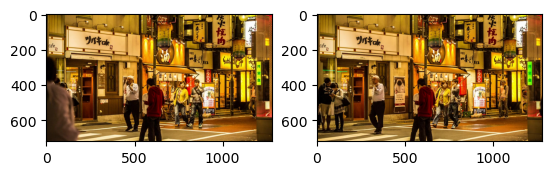

In [3]:
B = cv2.imread(r"data\testing_data\street_Moment1.jpg")
I = cv2.imread(r"data\testing_data\street_Moment2.jpg")

plt.subplot(121)
plt.imshow(B[:,:,::-1])
plt.subplot(122)
plt.imshow(I[:,:,::-1])

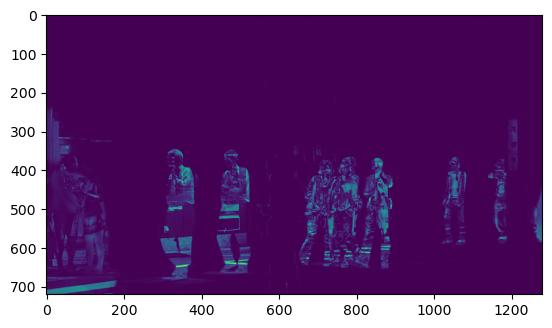

In [4]:
## Detecting change naively

B  = np.float32(B)
I = np.float32(I)
C = (B - I)**2 # squaring to ignore signs 

C.shape
C2 = np.sum(C,axis=2)
plt.imshow(C2)


The difference of the images is very clear and clean.

However, this method has a lot of errors when the frames are noisy, due to compresssion or the videos just being of a low quality. If we tried the same method for the subway video which is of lower quality, we would get significantly more noise. 

Instead to significantly improve this, we complete our change detection using Mixture of Gaussians method whcih significantly improves the process. It allows us to distinguish between objects in the background and objects in the foreground. 

We can improve this further by considering connected components in images, so that our change detection can be resilient to different conditions. For example, if we had a video of a tree on  a windy day, the leaves would be constantly moving and this would be detected as lots of change in our model. By considering connected components, the leaves become one connected component which doesn't move much so are included as part of the background. 

In [5]:
## Method to keep large connected components
def keepLargeComponents(I,th):
    R = np.zeros(I.shape)<0
    unique_labels = np.unique(I.flatten())
    # not that background labelled zero
    for label in unique_labels:
        if label == 0:
            pass
        else: 
            I2 = I==label
            if np.sum(I2)>th:
                R  = R | I2
    return np.float32(255*R)


In [15]:
def alphaBlend(foreground, background, alpha):

    foregroundNew = foreground.astype(float)
    backgroundNew = background.astype(float)
    alphaNew = alpha.astype(float)/255

    foregroundNew = cv2.multiply(alphaNew,foregroundNew)
    backgroundNew = cv2.multiply(1.0-alphaNew, backgroundNew)

    outImage = cv2.add(foregroundNew,backgroundNew)
    
    return outImage/255

In [22]:


## Useful Helper Functions

def saveSeq(framesArray,counter,threshold,outputPath):
    '''
    Purpose: Puts bounding boxes around images in a given array and saves them to an appropriate path
    '''
    if len(framesArray)< threshold:
        pass
    else:
        counter = 1
        for frame in framesArray:

            # Find somewhere to store the image
            imgName = f"image_{counter}.jpg"
            finalPath = os.path.join(outputPath,imgName)

            # draw bounding boxes
            bbox, labels, conf = cv.detect_common_objects(frame)
            frame = draw_bbox(frame,bbox,labels,conf)

            cv2.imwrite(finalPath,frame)
            counter +=1
            
def displaySeq(outputPath):
    '''
    Purpose: Display a sequence of saved images 
    '''
    for imgName in os.listdir(outputPath):
        frame = cv2.imread(os.path.join(outputPath,imgName))
        frame = cv2.resize(frame,dsize = (600,400))
        cv2.imshow('Displayy',frame)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break       
    cv2.destroyAllWindows()


def smartCCTV(vidPath, outputPath,counterThreshold = 100):


    '''
    Purpose: Given a video, the function will cleanly find changes to the background.
    It will use this information to detect and track relevant changes. 
    
    To do: If the detected behaviour is suspicious, label the data appropriately and send away the video snippet 
    evidence
    '''

    cap = cv2.VideoCapture(vidPath)
    fgModel = cv2.createBackgroundSubtractorMOG2()

    ## Initialise some values
    indexArray = []
    framesArray = []
    counter = 0
    framesThreshold = 5
    while(1):
        counter += 1
        
        ret, frame = cap.read() # gives us the individual frames
        frame = cv2.resize(frame,dsize = (600,400))
        fgmask = fgModel.apply(frame)
        
        ## Denoising using morphology - dilation and erosion
        kernel  = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
        fgmask = cv2.morphologyEx(np.float32(fgmask),cv2.MORPH_OPEN,kernel)
        
        # Improve denoising by considering connected components
        _, labels_img = cv2.connectedComponents(np.array(fgmask>0,np.uint8))
        fgmask = keepLargeComponents(labels_img,400)

        alpha = np.zeros(frame.shape,np.uint8)
        alpha[:,:,0],alpha[:,:,1],alpha[:,:,2] = fgmask,fgmask,fgmask
        background = np.zeros(frame.shape,np.uint8)

        colouredBackground = alphaBlend(frame, background,alpha)
        # Detect change in foreground and save it 
        if np.sum(fgmask)>0:
            indexArray.append(counter)
            framesArray.append(frame)
        if len(indexArray) >=2 and indexArray[-1]> indexArray[-2]+1:
            saveSeq(framesArray,counter,framesThreshold,outputPath)
        
        # Look at changes side by side with frame
        sideBySide  = np.hstack((frame/255,colouredBackground))
        
        cv2.imshow('Display Window', sideBySide)
        k = cv2.waitKey(20) & 0xff 

        if counter  == counterThreshold:
            break
    saveSeq(framesArray,counter,framesThreshold,outputPath)
    cap.release()
    cv2.destroyAllWindows()

vidPath = r"data\testing_data\street.mp4"
outputPath = r"data\interesting_sequences"
smartCCTV(vidPath, outputPath)

    

In [8]:

displaySeq(outputPath)